This code creates a heatmap that shows the average time to beaching in a given location

In [2]:
# set working directory
import os
os.chdir('/dat1/openonic/Drifters') # directory

In [3]:
# dependencies
import pandas as pd
import scipy.interpolate as sci_int
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sci_stats
import cartopy.crs as ccrs
import geopandas as gpd
from numba import jit, int64
import seaborn as sn
import random

#from plotly.offline import init_notebook_mode
#init_notebook_mode(connected=True)

In [4]:
# loading drifter data files
metadata = pd.read_csv('drifter data/global drifter program/csv files/GDP_metadata.csv')
beach_drogued = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_drouged.csv')
beach_undrogued = pd.read_csv('drifter data/global drifter program/csv files/GDP_RunAground_undrouged.csv')
unbeach_drogued= pd.read_csv('GDP_NonRunAground_drouged-004.csv')
unbeach_undrogued = pd.read_csv('GDP_NonRunAground_undrouged-006.csv')

In [5]:
beach_drogued

,ID,lat,lon,ve,vn,time
0,101509,10.01950,136.335663,-0.1005,0.0952,1323990000
1,101509,10.02242,136.332306,-0.0956,0.0941,1323993600
2,101509,10.02558,136.329834,-0.1227,0.1313,1323997200
3,101509,10.03013,136.325272,-0.1216,0.1332,1324000800
4,101509,10.03423,136.321274,-0.1219,0.1329,1324004400
...,...,...,...,...,...,...
14265860,9917894,-12.49475,172.784973,-0.1337,0.0368,970772400
14265861,9917894,-12.49576,172.779144,-0.1448,0.0301,970776000
14265862,9917894,-12.49523,172.773407,-0.2221,0.0554,970779600
14265863,9917894,-12.49281,172.765915,-0.2224,0.0584,970783200


In [6]:
# get lats and lons separated and assign 0 to those that do not beach
beach_drogued_lats = np.array(beach_drogued['lat'])
beach_drogued_longs = np.array(beach_drogued['lon'])

beach_undrogued_lats = np.array(beach_undrogued['lat'])
beach_undrogued_longs = np.array(beach_undrogued['lon'])

unbeach_drogued_lats = np.array(unbeach_drogued['lat'])
unbeach_drogued_longs = np.array(unbeach_drogued['lon'])
unbeach_drogued_values = np.zeros(len(unbeach_drogued))

unbeach_undrogued_lats = np.array(unbeach_undrogued['lat'])
unbeach_undrogued_longs = np.array(unbeach_undrogued['lon'])
unbeach_undrogued_values = np.zeros(len(unbeach_undrogued))

 Now let's visualize the time to beaching. <br> 
 We set time_values = 1 / time_to_beach, then  later set histogram plotting weights = 1 / time_values. This sets '0' never_beached values as 'infinite time.' 

In [7]:
# get the last time values of beached
beach_drogued_last = beach_drogued.drop_duplicates(subset='ID', keep='last') 
beach_undrogued_last = beach_undrogued.drop_duplicates(subset='ID', keep='last')

In [8]:
def find_time_to_beach(beach, beach_last,time_between_register_beaching_and_actually_beaching):
    # DF to Numpy Arrays
    beach_array = beach.to_numpy()
    beach_last_array = beach_last.to_numpy()

    # Create a dictionary to store the last known time for each ID
    last_time_dict = dict(zip(beach_last_array[:, 0], beach_last_array[:, 5]))

    beach_time = []

    # Iterate through beach array and calculate time differences
    for row in beach_array:
        current_ID = row[0]
        last_time = last_time_dict.get(current_ID, None)
        
        if last_time is not None:
            current_time = row[5]
            if current_time != last_time: # prevent 0 value --> infinite time as beach_last exists within beach
                time_difference = last_time - current_time
                beach_time.append(time_difference)
            if current_time == last_time: # keep lat, lon, and values for hist shape the same
                beach_time.append(time_between_register_beaching_and_actually_beaching)

    return beach_time

In [9]:
time_between_register_beaching_and_actually_beaching = 604800 # 1 week to beaching (?)
beach_drogued_time = find_time_to_beach(beach_drogued,beach_drogued_last, time_between_register_beaching_and_actually_beaching)
beach_undrogued_time = find_time_to_beach(beach_undrogued,beach_undrogued_last, time_between_register_beaching_and_actually_beaching)

In [10]:
# set time values as 1 / time
beach_drogued_time_inv = 1 / np.array(beach_drogued_time)
beach_undrogued_time_inv = 1 / np.array(beach_undrogued_time)

In [11]:
# concatenate all together into lats, longs variables for plotting
lats = np.concatenate((beach_drogued_lats, beach_undrogued_lats, unbeach_drogued_lats, unbeach_undrogued_lats))
longs = np.concatenate((beach_drogued_longs, beach_undrogued_longs, unbeach_drogued_longs, unbeach_undrogued_longs))

# concatenate both time to beaching and both unbeach 0 values
values = np.concatenate((beach_drogued_time_inv, beach_undrogued_time_inv, unbeach_drogued_values, unbeach_undrogued_values))
# take the inverse of values in order to set unbeached 0 values to infinity and return time values back to original
values_inv = 1 / values

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in true_divide
  


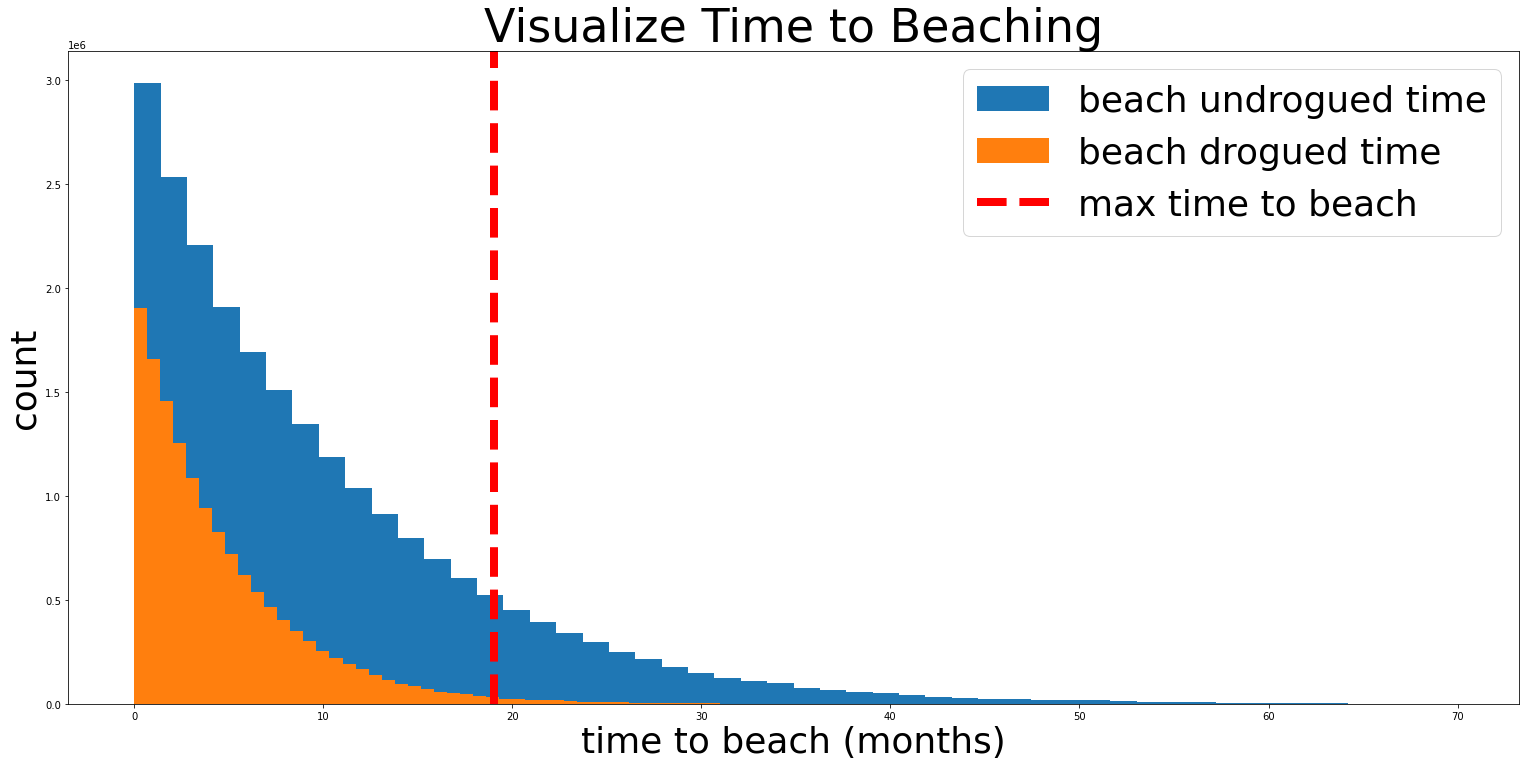

In [12]:
fig = plt.figure(figsize=(26, 12))
plt.hist((1/beach_undrogued_time_inv) / (2.628*10**6), label = 'beach undrogued time',bins = 50)
plt.hist(1/beach_drogued_time_inv / (2.628*10**6), label = 'beach drogued time',bins = 50)
plt.title('Visualize Time to Beaching', fontsize = 46)
plt.xlabel('time to beach (months)',fontsize=36)
plt.ylabel('count', fontsize = 36)
plt.axvline(x=(0.5*10**8) / (2.628*10**6), color='r', linestyle='--', label='max time to beach',linewidth = 8)
plt.legend(fontsize = 36)

In [13]:
# set max time_to_beach i.e, if a value is greater than max or infinity, we set it to the max
max_time_to_beach = 0.5*10**8
values_inv[values_inv == np.inf] = max_time_to_beach
values_inv[values_inv > max_time_to_beach] = max_time_to_beach

In [14]:
# set time scale from seconds to months
values_inv_month = values_inv / (2.628*10**6)

In [15]:
np.shape(values_inv_month)

(165754333,)

In [18]:
print("Shapes:")
print("longs shape:", longs.shape)
print("lats shape:", lats.shape)
print("values_inv_month shape:", values_inv_month.shape)

Shapes:
longs shape: (165754333,)
lats shape: (165754333,)
values_inv_month shape: (165754333,)


In [19]:
n_lons, n_lats = 720, 360 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)
statistic, x_edge, y_edge, binnumber = sci_stats.binned_statistic_2d(longs,lats,values=values_inv_month,bins = [lon_bins,lat_bins])

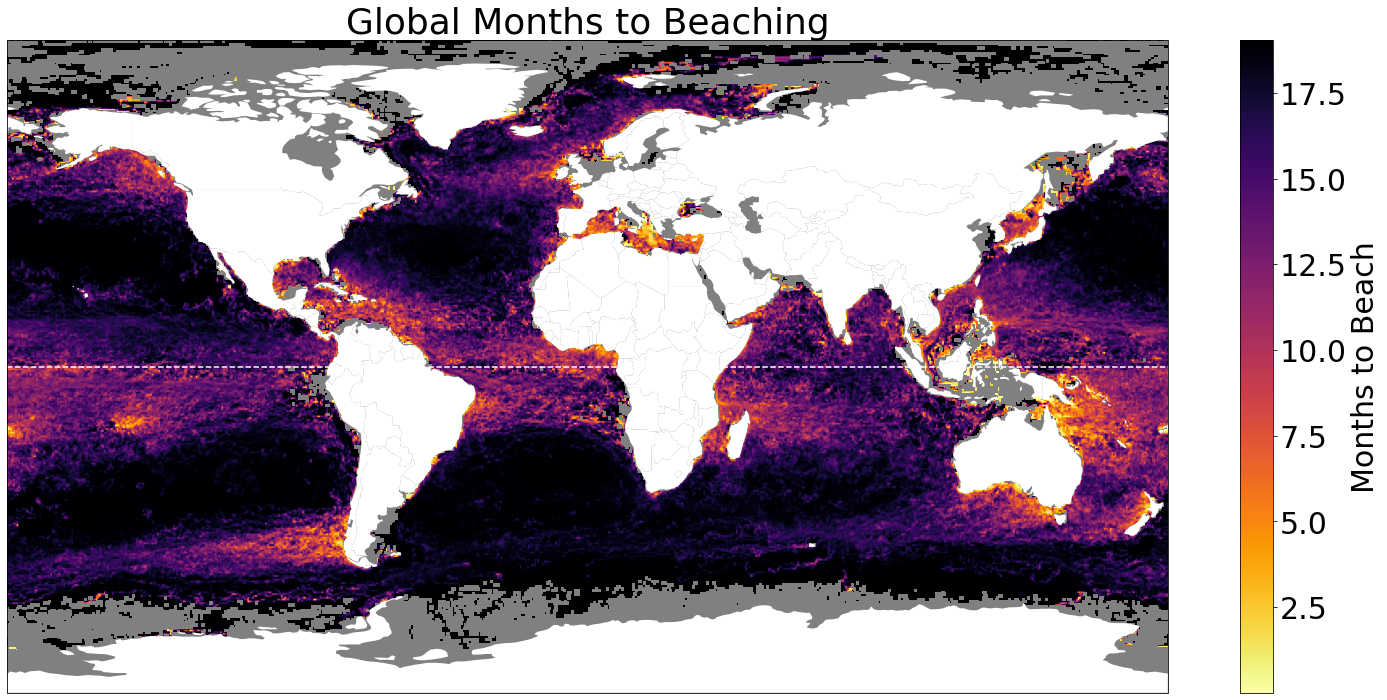

In [20]:
# Given location, time to beaching

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno_r").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(statistic.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Months to Beach')
ax.set_aspect('auto')
plt.title('Global Months to Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')



goal 1 <br>
bin average velocity and plot larger bin streamlines <br>
download SSH and plot as contour lines on plot <br>
analyze surface winds on here

goal 2 <br>
make map that shows probability of beaching

probability of beaching <br>
once you're close to the coast, drift around and come out or just beach. Make metric of:
once a drifter has entered a nearby coast area, what is the probability that it will in fact beach. Could go like 100km box. <br>
make box, count number that escape vs number that dont escape. ratio of beached particles in that box to all particles in that box

### Let's plot average velocities on our heat map

In [462]:
dataframes = [beach_drogued, beach_undrogued, unbeach_drogued, unbeach_undrogued]

# Calculate velocity magnitude from north-south and east-west components 
# and append to existing dataframe as new column
for df in dataframes:
    vel_mag = np.sqrt((df['ve'])**2 + (df['vn'])**2)
    df['vel mag'] = np.array(vel_mag)
    
# Calculate velocity direction from north-south and east-west components and 
# append to existing dataframe as new column
for df in dataframes:
    angle_rad = np.arctan2(df['vn'], df['ve']) # Calculate the angle using arctan2 function
    angle_deg = np.degrees(angle_rad) # Convert angle from radians to degrees
    angle_deg_pos = (angle_deg + 360) % 360 # Ensure the angle is in the range [0, 360) degrees
    df['vel dir'] = np.array(angle_deg_pos) # Append as new column

# Concatenate into one 
v_mags = np.concatenate([df['vel mag'].values for df in dataframes])
v_dirs = np.concatenate([df['vel dir'].values for df in dataframes])

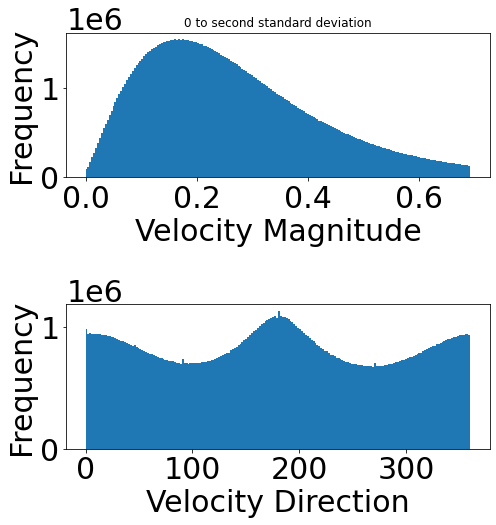

In [482]:
v_mags_cut = np.where(v_mags > (2 * np.std(v_mags) +np.mean(v_mags)), np.nan, v_mags)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot histogram of v_mags from 0 to second standard deviation on the first subplot (ax1)
ax1.hist(v_mags_cut, bins=200)
ax1.set_title('0 to second standard deviation', fontsize = 12)
ax1.set_xlabel('Velocity Magnitude')
ax1.set_ylabel('Frequency')

# Plot histogram of v_dirs on the second subplot (ax2)
ax2.hist(v_dirs, bins=200)
#ax2.set_title('Velocity Direction Histogram')
ax2.set_xlabel('Velocity Direction')
ax2.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

In [485]:
# bin average velocity magnitude
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)
v_mag_statistic, v_mag_x_edge, v_mag_y_edge, v_mag_binnumber = sci_stats.binned_statistic_2d(longs,lats,values=v_mags,bins = [lon_bins,lat_bins])

In [486]:
# bin average velocity direction
n_lons, n_lats = 360, 180 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)
v_dir_statistic, v_dir_x_edge, v_dir_y_edge, v_dir_binnumber = sci_stats.binned_statistic_2d(longs,lats,values=v_dirs,bins = [lon_bins,lat_bins])

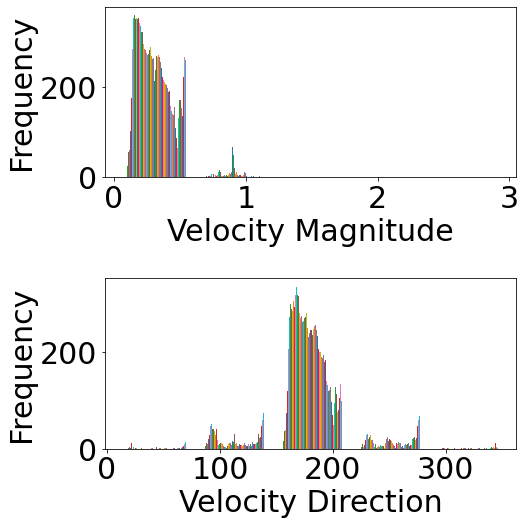

In [488]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

# Plot histogram of v_mag_statistic from 0 to second standard deviation on the first subplot (ax1)
ax1.hist(v_mag_statistic, bins=5)
#ax1.set_title('0 to second standard deviation', fontsize = 12)
ax1.set_xlabel('Velocity Magnitude')
ax1.set_ylabel('Frequency')

# Plot histogram of v_dir_statistic on the second subplot (ax2)
ax2.hist(v_dir_statistic, bins=5)
#ax2.set_title('Velocity Direction Histogram')
ax2.set_xlabel('Velocity Direction')
ax2.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

In [465]:
lon_mesh, lat_mesh = np.meshgrid(v_dir_y_edge[:11],v_dir_x_edge[:22])

In [451]:
print(np.shape(v_dir_statistic))
print(np.shape(v_mag_statistic))

print(np.shape(lon_mesh))
print(np.shape(lat_mesh))

print(np.shape(v_dir_y_edge))
print(np.shape(v_dir_x_edge))


(22, 11)
(22, 11)
(22, 11)
(22, 11)
(12,)
(23,)


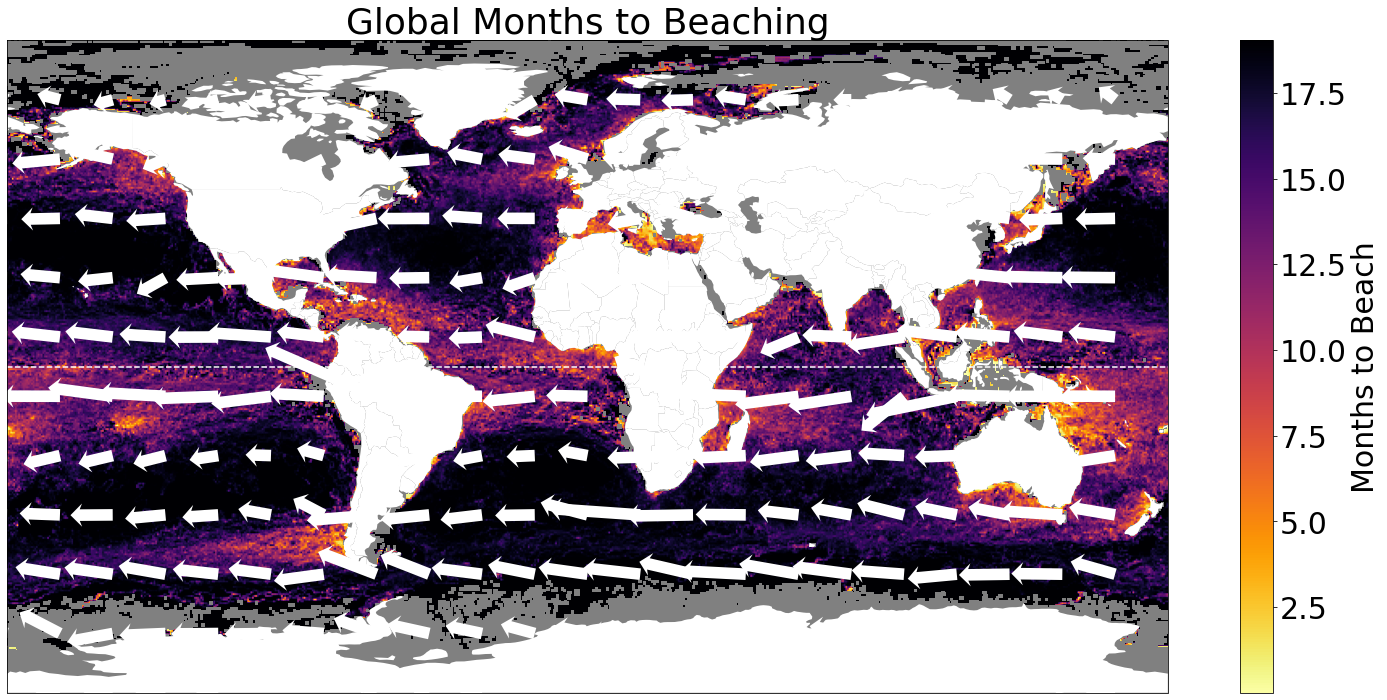

In [466]:
# Given location, time to beaching

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno_r").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(statistic.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Plotting parameters for quiver plot
quiver_scale = 0.02  # Scale factor for the arrows
quiver_width = 0.01  # Width of the arrows

# Convert direction from degrees to radians
v_dir_rad = np.radians(v_dir_statistic)

# Calculate arrow components
u = v_mag_statistic * np.cos(v_dir_rad)
v = v_mag_statistic * np.sin(v_dir_rad)

# Plot arrows
ax.quiver(lat_mesh, lon_mesh, u, v, angles='xy', scale_units='xy', scale=quiver_scale,
          pivot='tail', width=quiver_width, color='white', headwidth = 2, headlength = 1, headaxislength = 0.8)
# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Months to Beach')
ax.set_aspect('auto')
plt.title('Global Months to Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')

### Let's plot average velocities on our heat map

In [27]:
# collect velocity components into single variables
ve = np.concatenate((beach_drogued['ve'], beach_undrogued['ve'], unbeach_drogued['ve'], unbeach_undrogued['ve']))
vn = np.concatenate((beach_drogued['vn'], beach_undrogued['vn'], unbeach_drogued['vn'], unbeach_undrogued['vn']))

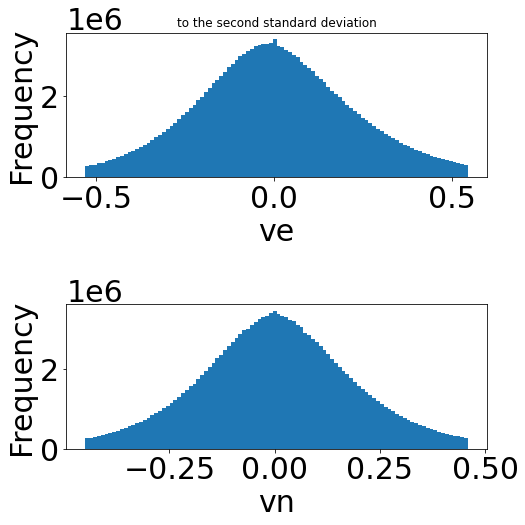

In [40]:
# lets visualize our data with histograms to see their distributions
ve_cut = np.where(ve < (np.mean(ve)) - 2 * np.std(ve), np.nan, ve)
ve_cut = np.where(ve_cut > (2 * np.std(ve) +np.mean(ve)), np.nan, ve_cut)

vn_cut = np.where(vn < (np.mean(vn)) - 2 * np.std(vn), np.nan, vn)
vn_cut = np.where(vn_cut > (2 * np.std(vn) +np.mean(vn)), np.nan, vn_cut)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.hist(ve_cut, bins=100)
ax1.set_title('to the second standard deviation', fontsize = 12)
ax1.set_xlabel('ve')
ax1.set_ylabel('Frequency')

ax2.hist(vn_cut, bins=100)
#ax2.set_title('vn')
ax2.set_xlabel('vn')
ax2.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

In [148]:
# let's bin average ve and vn
n_lons, n_lats = 90, 45 # Define the number of grid cells
lon_bins = np.linspace(-180, 180, n_lons + 1)
lat_bins = np.linspace(-90, 90, n_lats + 1)

# bin average ve
ve_statistic, ve_x_edge, ve_y_edge, ve_binnumber = sci_stats.binned_statistic_2d(longs,lats,values=ve,bins = [lon_bins,lat_bins])

# bin average vn
vn_statistic, vn_x_edge, vn_y_edge, vn_binnumber = sci_stats.binned_statistic_2d(longs,lats,values=vn,bins = [lon_bins,lat_bins])

In [149]:
# Calculate velocity magnitude from north-south and east-west components statistics
vel_mag = np.sqrt((ve_statistic**2 + vn_statistic**2))
    
# Calculate velocity direction from north-south and east-west components statistics
angle_rad = np.arctan2(ve_statistic, vn_statistic) # Calculate the angle using arctan2 function
angle_deg = np.degrees(angle_rad) # Convert angle from radians to degrees
angle_deg_pos = (angle_deg + 360) % 360 # Ensure the angle is in the range [0, 360) degrees

# create lat-lon mesh
lon_mesh, lat_mesh = np.meshgrid(ve_y_edge[:45],ve_x_edge[:90])

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in remainder
  import sys


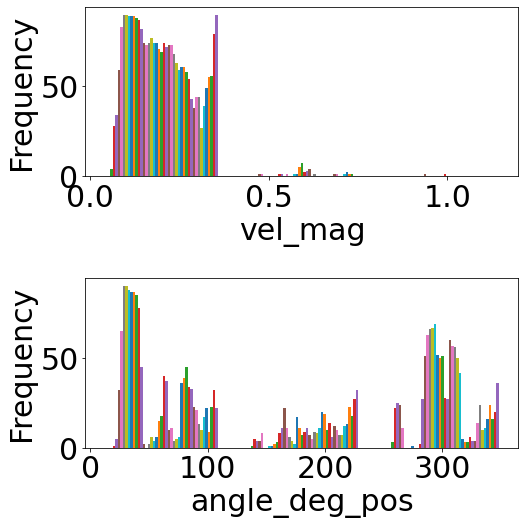

In [151]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

ax1.hist(vel_mag, bins=3)
#ax1.set_title('n', fontsize = 12)
ax1.set_xlabel('vel_mag')
ax1.set_ylabel('Frequency')

ax2.hist(angle_deg_pos, bins=3)
#ax2.set_title('vn')
ax2.set_xlabel('angle_deg_pos')
ax2.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()

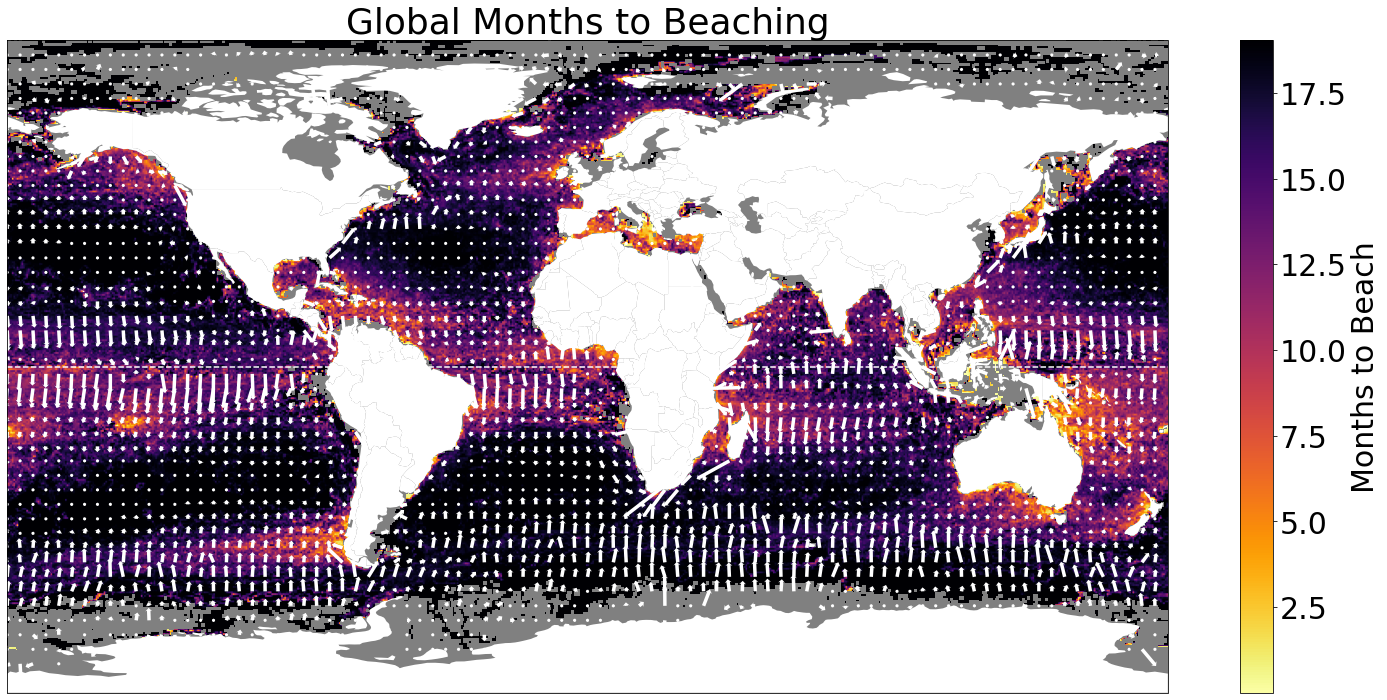

In [154]:
# Given location, time to beaching

fig = plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 30})
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([-180, 180, -90, 90], crs=ccrs.PlateCarree())

# colormap
cmap = plt.cm.get_cmap("inferno_r").copy()
cmap.set_bad('grey')

# plot hist on world
plt.imshow(statistic.T, origin='lower', extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], cmap=cmap)

# Plotting parameters for quiver plot
quiver_scale = 0.06  # Scale factor for the arrows
quiver_width = 0.003  # Width of the arrows

# Convert direction from degrees to radians
v_dir_rad = np.radians(angle_deg_pos)

# Calculate arrow components
u = vel_mag * np.cos(v_dir_rad)
v = vel_mag * np.sin(v_dir_rad)

# Plot arrows
ax.quiver(lat_mesh, lon_mesh, u, v, angles='xy', scale_units='xy', scale=quiver_scale,
          pivot='tail', width=quiver_width, color='white', headwidth = 2, headlength = 1, headaxislength = 0.8)
# Load the world shapefile from GeoPandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract the land polygons
land = world[world['continent'] != 'Antarctica']
Antarctica = world[world['continent'] == 'Antarctica']
land.plot(ax=ax, color='white', edgecolor='none')
Antarctica.plot(ax=ax, color='white', edgecolor='none')

plt.colorbar(label='Months to Beach')
ax.set_aspect('auto')
plt.title('Global Months to Beaching')
plt.axhline(y=0, color='white', linestyle='--', label='Equator')